In [20]:
%%javascript

# Bind cmd-shift-d to duplicate line of code
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('cmd-shift-d', {
    help : 'Duplicate current line',
    help_index : 'zz',
    handler: function(env) {
        var cm=env.notebook.get_selected_cell().code_mirror;
        // get a position of a current cursor in a current cell
        var current_cursor = cm.doc.getCursor();

        // read a content from a line where is the current cursor
        var line_content = cm.doc.getLine(current_cursor.line);
        cm.execCommand('goLineEnd');
        cm.execCommand('newlineAndIndent');
        cm.execCommand('indentLess');
        cm.doc.replaceSelection(line_content);
        cm.doc.setCursor(current_cursor.line + 1, current_cursor.ch);
        return false;
    }}
);

<IPython.core.display.Javascript object>

__Universal Robot Control__

In [40]:
import urx
import time, pickle
import numpy as np
import math3d as m3d

In [82]:
robot = urx.Robot("10.42.0.16", use_rt=True)

tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 69
tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 1093
tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 1418


In [10]:
robot.set_digital_out(0, 1)
time.sleep(1)
robot.set_digital_out(0, 0)

In [16]:
robot.set_tcp((0, 0, 0.5, 0, 0, 0)) #ckeck Installation tab

In [14]:
robot.translate((0, 0, -0.05), acc=0.05, vel=0.05) #acceleration, velocity

<Transform:
<Orientation: 
array([[-0.09891123,  0.83688643, -0.53836575],
       [-0.4089152 , -0.52741222, -0.7447313 ],
       [-0.90719619,  0.14648365,  0.39438258]])>
<Vector: (-0.11497, -0.37466, 0.27273)>
>

In [44]:
robot.translate_tool((0, 0, -0.03), acc=0.05, vel=0.05)

<Transform:
<Orientation: 
array([[-0.16890046,  0.84351886, -0.50985152],
       [-0.51851251, -0.51596101, -0.68185703],
       [-0.83822277,  0.14919842,  0.52452113]])>
<Vector: (-0.42497, -0.62617, 0.69468)>
>

In [17]:
robot.get_pose()

<Transform:
<Orientation: 
array([[-0.09903769,  0.83682725, -0.53843449],
       [-0.40897296, -0.52751299, -0.7446282 ],
       [-0.90715635,  0.14645889,  0.39448339]])>
<Vector: (-0.35730, -0.70976, 0.45021)>
>

In [50]:
robot.get_pos()

<Vector: (-0.36120, -0.21739, 0.73764)>

In [51]:
robot.getl()

[-0.36120579612287107,
 -0.21735303165463984,
 0.7376364001750049,
 0.04533037032833755,
 0.01790177367091024,
 -0.07310780230245217]

In [52]:
def save_current_pos(fname):
    p = robot.get_pos()
    np.savetxt(fname, p.array)
       

def move_to_pos(fname, *args, **kwargs):
    p = np.loadtxt(fname)
    robot.movel((*p, 0, 0, 0), *args, **kwargs)
    

In [53]:
save_current_pos("in")

In [28]:
save_current_pos("out")

In [55]:
move_to_pos("in")

In [60]:
robot.x += 0.01 #1 hour 10 minutes up to this point

In [59]:
p = robot.get_pos()

In [37]:
p.array

array([-0.44037436, -0.64668612,  0.71023683])

In [41]:
m3d.Vector(p.array)

<Vector: (-0.44037, -0.64669, 0.71024)>

In [93]:
import threading
from IPython.display import display
import ipywidgets as widgets
import time

fw = widgets.HTML(
    value='',
    placeholder='No data',
    description='Force:',
)

def observe_force(fw):
    while True:
        fw.value = "<br>".join(["{0:5} {1:7.3f}".format(*c) for c in 
                                zip("x y z rx ry rz".split(), robot.get_tcp_force())])

thread = threading.Thread(target=observe_force, args=(fw,))
display(fw)
thread.start()



Exception in thread Thread-17:
Traceback (most recent call last):
  File "/home/dima/apps/anaconda3/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/dima/apps/anaconda3/lib/python3.5/site-packages/urx/ursecmon.py", line 280, in run
    data = self._get_data()
  File "/home/dima/apps/anaconda3/lib/python3.5/site-packages/urx/ursecmon.py", line 327, in _get_data
    tmp = self._s_secondary.recv(1024)
socket.timeout: timed out



In [85]:
robot.get_tcp_force().__str__()

'[-8.08827697  0.45056171  3.53951352  0.65056199  4.44886816 -0.04827402]'

__Here starts CV__

In [7]:
%matplotlib notebook

import cv2 #pip install opencv-python
import matplotlib.pyplot as plt
import signal, time
import numpy as np
from numpy import linalg
#to check: cv2.getBuildInformation()
print (*filter(lambda s: "FFMPEG" in s, cv2.getBuildInformation().split("\n")))
#for opencv with ffmpeg in conda
#https://github.com/conda-forge/opencv-feedstock/
#pip uninstall opencv
#pip uninstall opencv-python
#conda unistall opencv
#conda install conda=4.0.11
#conda config --add channels conda-forge
#conda install opencv


    FFMPEG:                      YES


In [2]:
def signal_handler(signal, frame):
    # KeyboardInterrupt detected, exiting
    global is_interrupted
    is_interrupted = True

In [14]:
%%bash
ls /dev | grep video

video0
video2


In [15]:
vc = cv2.VideoCapture(2) #0 for the first webcam, 1 for the second..

In [87]:
def imshow(frame, from_color_space='bgr'):
    plt.figure()
    if from_color_space == 'bgr':
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    elif from_color_space == 'hsv':
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_HSV2RGB)    # makes the blues image look real colored
    else:
        rgb_frame=frame
    webcam_preview = plt.imshow(rgb_frame)

def online_view():
    plt.ion()

    if vc.isOpened(): # try to get the first frame
        is_capturing, frame = vc.read()
        imshow(frame)   
    else:
        is_capturing = False

    signal.signal(signal.SIGINT, signal_handler)
    is_interrupted = False
    while is_capturing:
        is_capturing, frame = vc.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
        webcam_preview.set_data(frame)
        plt.draw()

        try:    # Avoids a NotImplementedError caused by `plt.pause`
            plt.pause(0.05)
        except Exception:
            pass
        if is_interrupted:
            vc.release()
            break
    
def get_frame():
    timeout = time.time() + 0.1
    while time.time() < timeout:
        if vc.isOpened(): # try to get the first frame
            is_capturing, frame = vc.read()
        else:
            raise (Exception("Unable to capture"))
    return frame


#frame = get_frame()
#imshow(frame)

#online_view()

In [51]:
def display_color(color):
    import matplotlib.patches as patches

    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, aspect='equal')
    ax1.add_patch(
        patches.Rectangle(
            (0., 0.),   # (x,y)
            1,          # width
            1,          # height
            color=color
        )
    )

In [52]:
from scipy.stats import itemfreq
def get_dominant_color(frame, show_quantized=False):
    arr = np.float32(frame)
    pixels = arr.reshape((-1, 3))

    n_colors = 2
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, labels, centroids = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
    
    #print (_, labels, centroids)

    palette = np.uint8(centroids)
    quantized = palette[labels.flatten()]
    quantized = quantized.reshape(frame.shape)
    
    if show_quantized: imshow(quantized)
    
    hist = itemfreq(labels)[:, -1]
    max_color = np.argmax(hist)

    dominant_color = palette[max_color]
    dominance = np.max(hist)/np.sum(hist)
    return dominant_color, dominance

#get_dominant_color(frame)

<IPython.core.display.Javascript object>


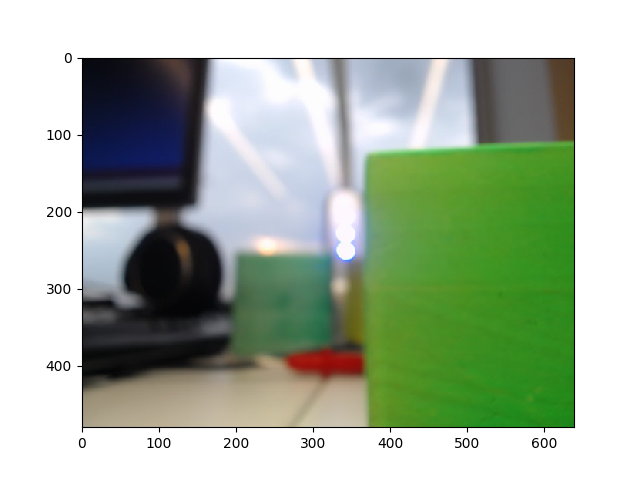

<IPython.core.display.Javascript object>


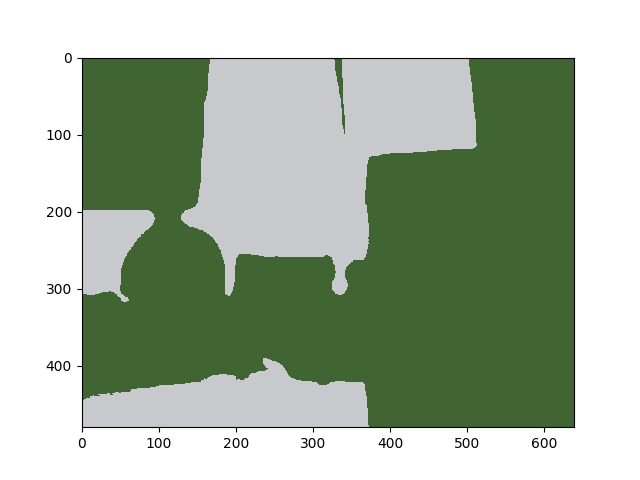

0.667867838542


<IPython.core.display.Javascript object>


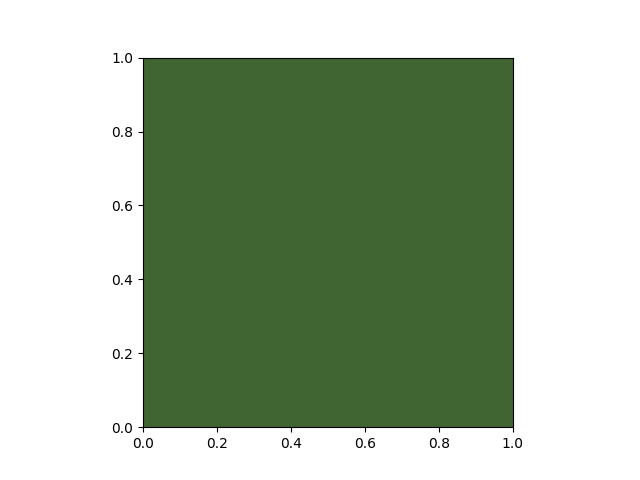

In [54]:
frame = get_frame()
imshow(frame)
dominant_color, dominance = get_dominant_color(frame, show_quantized=True)
print (dominance)
display_color(dominant_color[::-1]/256.)

In [ ]:
dominant_color[::-1]

In [27]:
def sample_dominant_colors(num_samples = 20):
    dominant_colors = []
    dominances = []
    for i in range(num_samples):
        dc, d = get_dominant_color(get_frame())
        dominant_colors.append(dc)
        dominances.append(d)
    dominant_colors = np.vstack(dominant_colors)
    dominances = np.array(dominances)
    return dominant_colors, dominances

dominant_colors, dominances = sample_dominant_colors()

In [33]:
valid = dominances > 0.6
the_green = dominant_colors[valid].mean(axis=0)


In [32]:
dominances

array([ 0.73226563,  0.73239909,  0.70287435,  0.61307292,  0.55139323,
        0.75731445,  0.52624349,  0.71382161,  0.78863932,  0.66781901,
        0.66165039,  0.686875  ,  0.62564128,  0.63492839,  0.67155599,
        0.6366569 ,  0.57735677,  0.64542643,  0.52786133,  0.78436849])

In [34]:
linalg.norm(dominant_colors - the_green, axis=1)

array([   8.55222924,    8.55222924,   11.01774137,  158.72819732,
        143.24590963,   21.85499085,   20.05344422,   37.05591215,
         21.06277819,   22.08824631,   19.10211049,   17.58239531,
         58.12392472,   17.61790637,   68.62135692,   44.50158003,
        157.42185561,   28.14055126,  189.28520974,  143.40551114])

In [42]:
def detect_green_cube():
    f = get_frame()
    imshow(f)
    dominant_color, dominance = get_dominant_color(f)
    return (linalg.norm(dominant_color - the_green) < 50. and dominance > 0.6)

<IPython.core.display.Javascript object>


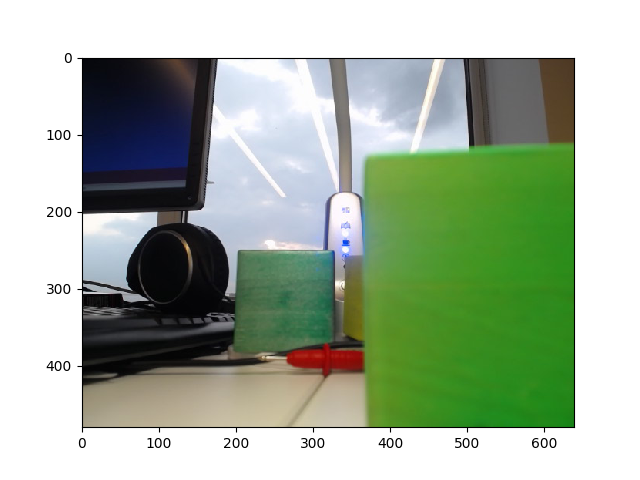

True

In [55]:
detect_green_cube()

__The blob detection__

<IPython.core.display.Javascript object>


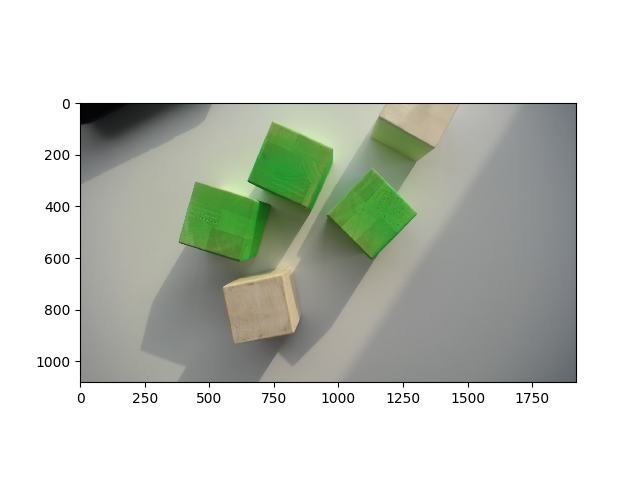

255

In [38]:
# Read image
im = cv2.imread("detection/cubes_5.png")

# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 10
params.maxThreshold = 200


# Filter by Area.
params.filterByArea = True
params.minArea = 1500

params.filterByColor = True
params.blobColor = 255

# Filter by Circularity
# params.filterByCircularity = True
# params.minCircularity = 0.1

# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.1

# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.1

 
# Set up the detector with default parameters.
detector = cv2.SimpleBlobDetector_create(params)
 
# Detect blobs.
keypoints = detector.detect(im)
 
# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
# Show keypoints
imshow(im_with_keypoints)
cv2.waitKey(0)

<IPython.core.display.Javascript object>


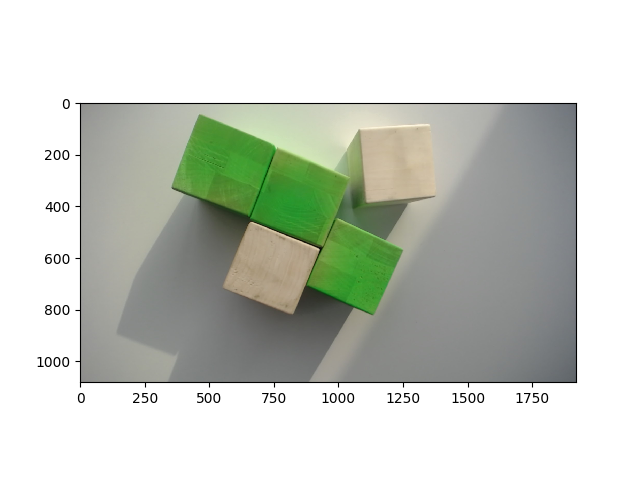

<IPython.core.display.Javascript object>


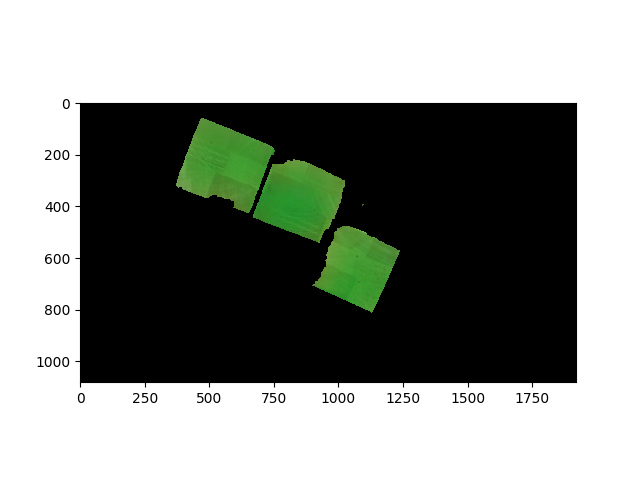

In [133]:
# Read image
im = cv2.imread("detection/cubes_4.png")

imshow(im)

# Blur image to remove noise
im = cv2.GaussianBlur(im, (5,5), 40)

# imshow(im)

hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

greenMin = (45, 115, 100)
greenMax = (70, 255, 255)

# Sets pixels to white if in purple range, else will be set to black
mask = cv2.inRange(hsv, greenMin, greenMax)

# Bitwise-AND of mask and purple only image - only used for display
masked = cv2.bitwise_and(im, im, mask= mask)

# imshow(masked)

# dilate makes the in range areas larger
mask = cv2.erode(mask, None, iterations=5)

# mask = cv2.dilate(mask, None, iterations=8)


# Bitwise-AND of mask and purple only image - only used for display
masked = cv2.bitwise_and(im, im, mask= mask)

imshow(masked)

In [134]:
# Set up the SimpleBlobdetector with default parameters.
params = cv2.SimpleBlobDetector_Params()

params.blobColor = 255

# Change thresholds
params.minThreshold = 0;
params.maxThreshold = 256;

# Filter by Area.
params.filterByArea = True
params.minArea = 3000

# Filter by Circularity
params.filterByCircularity = False
# params.minCircularity = 0.1

# Filter by Convexity
params.filterByConvexity = False
# params.minConvexity = 0.3

# Filter by Inertia
params.filterByInertia = False
# params.minInertiaRatio = 0.02

detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs.

keypoints = detector.detect(mask)

no blobs


<IPython.core.display.Javascript object>


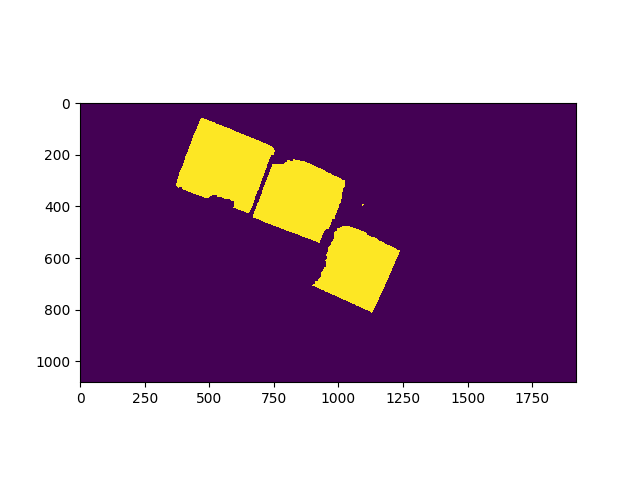

<IPython.core.display.Javascript object>


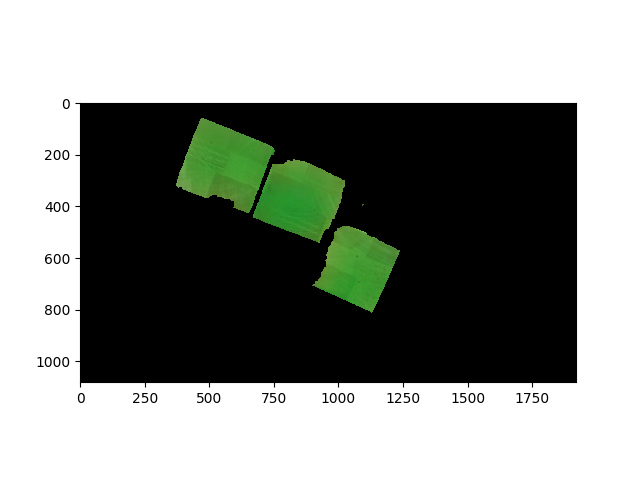

<IPython.core.display.Javascript object>


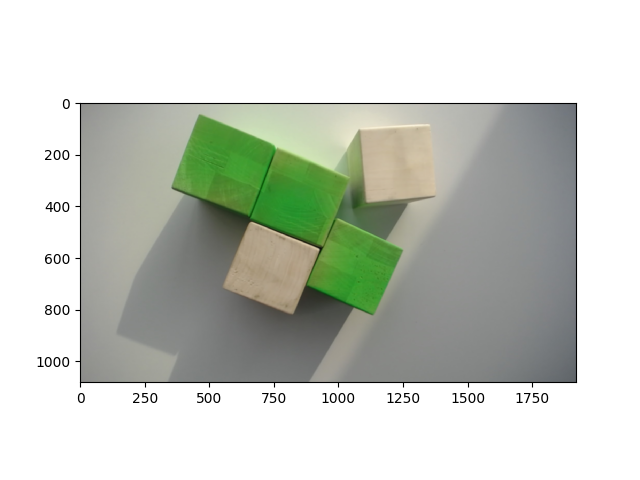

In [135]:
if keypoints:
    print ("found %d blobs" % len(keypoints))
    if len(keypoints) > 4:
        # if more than four blobs, keep the four largest
        keypoints.sort(key=(lambda s: s.size))
        keypoints=keypoints[0:3]
else:
    print ("no blobs")

# Draw green circles around detected blobs
im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# open windows with original image, mask, res, and image with keypoints marked
imshow(mask, 'grey')
imshow(masked)
imshow(im_with_keypoints)            


In [136]:
pts = []

# find contours in the mask and initialize the current
# (x, y) center of the ball
cnts = cv2.findContours(mask.copy(), cv2.RETR_LIST,
    cv2.CHAIN_APPROX_SIMPLE)[-2]
center = None

print (len(cnts))

# only proceed if at least one contour was found
for c in cnts:
    # find the largest contour in the mask, then use
    # it to compute the minimum enclosing circle and
    # centroid
#     c = max(cnts, key=cv2.contourArea)
    ((x, y), radius) = cv2.minEnclosingCircle(c)

    # only proceed if the radius meets a minimum size
    if radius > 100:
        print (radius)
        
        M = cv2.moments(c)
        center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
        # draw the circle and centroid on the frame,
        # then update the list of tracked points
        cv2.circle(im, (int(x), int(y)), int(radius),
            (0, 255, 255), 2)
        cv2.circle(im, center, 5, (0, 0, 255), -1)

        # update the points queue
        pts.append(center)

imshow(im)

5


ZeroDivisionError: float division by zero

In [126]:
pts

[(563, 466), (1128, 432), (819, 256)]